## PyTorch CEA model
Based on this code: https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

In [1]:
import time
import types

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchsummary import summary

from logger import TBLogger

%load_ext autoreload
%autoreload 2

In [2]:
debug_vals = types.SimpleNamespace()

### Load Data

In [3]:
from matplotlib.image import imread
from extract_patches import *

In [4]:
img_name = 'ESP_011261_1960_RED0_0.IMG'
images, ids = extract_patches_from_img(img_name, patch_size=256)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2575: DecompressionBombWarning: Image size (102400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(np.squeeze(img))

In [6]:
def show_img_grid(images, grid_shape = (4, 4)):
    fig, img_plots = plt.subplots(*grid_shape, figsize=(8, 8), gridspec_kw = {'wspace':0.05, 'hspace':0.05})

    fig.patch.set_facecolor('black')

    for i in range(0, grid_shape[0]):
        for j in range(0, grid_shape[1]):
            img_plt = img_plots[i, j]

            img = images[i * grid_shape[1] + j]
            img_plt.imshow(np.squeeze(img), cmap="afmhot")
            img_plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


In [8]:
from pytorch_utils import *

tensor_images = numpy_images_to_tensor_dataset(images)

In [9]:
tensor_images.size()

torch.Size([1564, 1, 256, 256])

In [10]:
try:
    # we need it because of cuda bug:
    # https://github.com/pytorch/pytorch/issues/17108
    _ = torch.cuda.current_device()
except:
    pass

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load saved Model

In [11]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=20, H=16, W=16):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
        
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

In [12]:
class ConvAutoencoderV2(nn.Module):
    def __init__(self, image_channels=1):
        super(ConvAutoencoderV2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 5, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(5, 10, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(10, 15, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(15, 20, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(20, 25, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            Flatten(),
        )
        
        self.decoder = nn.Sequential(
            Unflatten(C=25, H=8, W=8),
            
            nn.ConvTranspose2d(25, 20, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(20, 15, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(15, 10, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(10, 5, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(5, image_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

summary(ConvAutoencoderV2().to(device), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 128, 128]             130
         LeakyReLU-2          [-1, 5, 128, 128]               0
            Conv2d-3           [-1, 10, 64, 64]           1,260
         LeakyReLU-4           [-1, 10, 64, 64]               0
            Conv2d-5           [-1, 15, 32, 32]           3,765
         LeakyReLU-6           [-1, 15, 32, 32]               0
            Conv2d-7           [-1, 20, 16, 16]           7,520
         LeakyReLU-8           [-1, 20, 16, 16]               0
            Conv2d-9             [-1, 25, 8, 8]          12,525
        LeakyReLU-10             [-1, 25, 8, 8]               0
          Flatten-11                 [-1, 1600]               0
        Unflatten-12             [-1, 25, 8, 8]               0
  ConvTranspose2d-13           [-1, 20, 16, 16]           8,020
        LeakyReLU-14           [-1, 20,

In [18]:
model = torch.load('./logs/cae_v5_lrelu_11/model_e_49.model')
model = model.to(device)

### Test

In [19]:
def predict(images):
    model.eval()
    test_data = images
    test_data = test_data.to(device)

    # forward
    test_output = model(test_data)
    
    return test_output.data.cpu().numpy()


def predict_and_print(images):
    predicted_images = predict(images)

    show_img_grid(predicted_images)


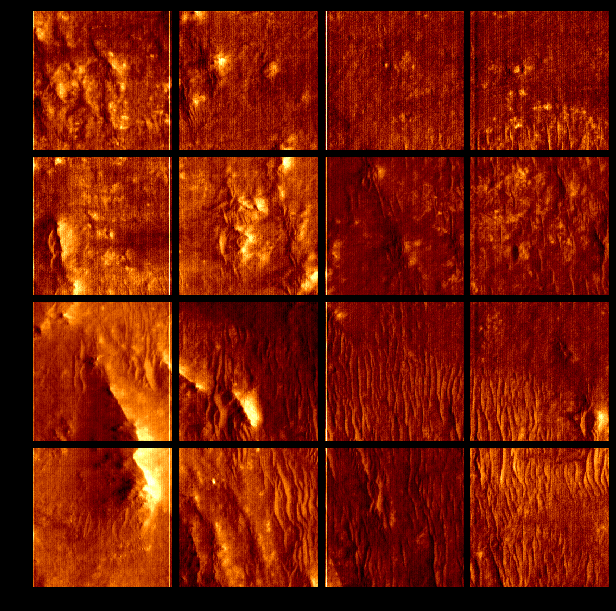

In [20]:
show_img_grid(tensor_images[:16])

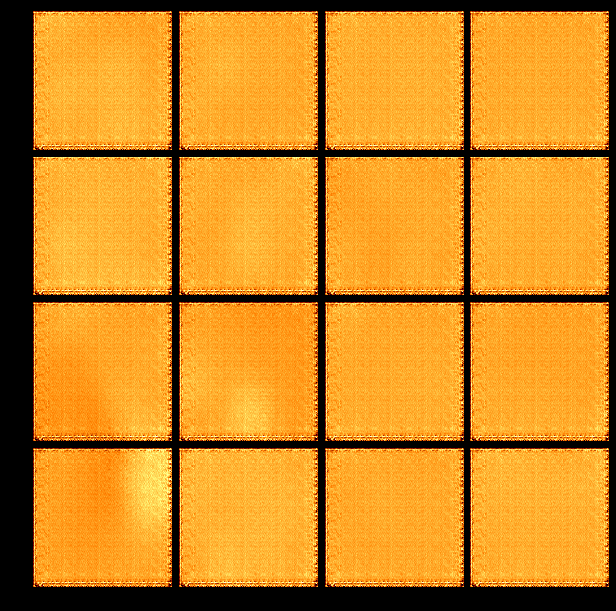

In [21]:
predict_and_print(tensor_images[:16])

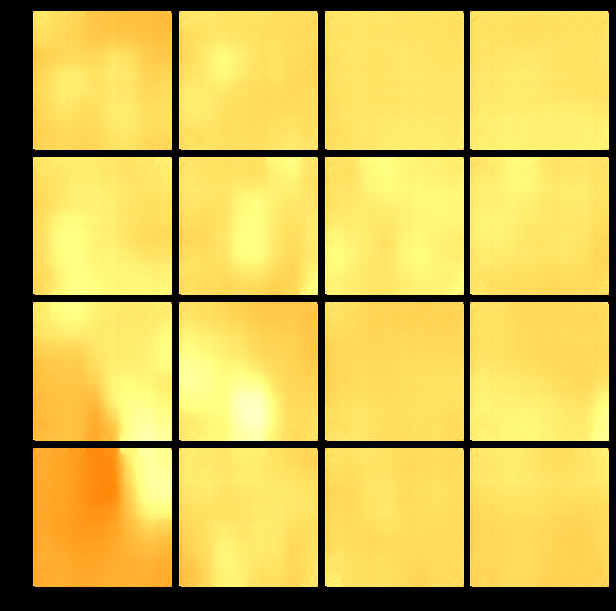

In [17]:
test_images = tensor_images[:16]
predicted_images = predict(test_images)
show_img_grid(predicted_images)